In [1]:
import os

all_files = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        all_files.append(os.path.join(dirname, filename)) 

# 1. Data Preparation

## Import libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim 
from PIL import Image 
import cv2 

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}") 

Using device: cuda


## Data Loading and DataFrame Creation

In [4]:
base_directory = '/kaggle/input/brain-tumor-mri-dataset'
train, test = 'Training', 'Testing' 
target_size = (224, 224)
batch_size = 32
num_classes = 4
categories = os.listdir(base_directory+'/'+train)
print(categories) 
label_map = {
    'notumor': 0,        
    'glioma': 1,         
    'meningioma': 2,     
    'pituitary': 3       
} 

['pituitary', 'notumor', 'meningioma', 'glioma']


In [5]:
from torchvision.transforms import transforms 
custom_transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
]) 

In [6]:
def create_dataset(path):
    my_list = [] 
    for category in categories:
        category_path = os.path.join(path, category)
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                my_list.append([file_path, category])
    return pd.DataFrame(my_list, columns=['file_path', 'label']) 

In [7]:
train_df = create_dataset(base_directory+'/'+train)
test_df = create_dataset(base_directory+'/'+test) 

In [8]:
train_df['label'] = train_df['label'].map(label_map)
test_df['label'] = test_df['label'].map(label_map) 

In [9]:
train_df.head()

,file_path,label
0,/kaggle/input/brain-tumor-mri-dataset/Training...,3
1,/kaggle/input/brain-tumor-mri-dataset/Training...,3
2,/kaggle/input/brain-tumor-mri-dataset/Training...,3
3,/kaggle/input/brain-tumor-mri-dataset/Training...,3
4,/kaggle/input/brain-tumor-mri-dataset/Training...,3


In [10]:
rows = test_df[test_df["file_path"].str.contains("Te-glTr_0007")]
print(rows)


                                              file_path  label
1109  /kaggle/input/brain-tumor-mri-dataset/Testing/...      1


In [11]:
test_df.iloc[784]  

file_path    /kaggle/input/brain-tumor-mri-dataset/Testing/...
label                                                        2
Name: 784, dtype: object

In [12]:
test_df = test_df.reset_index(drop=True) 

## DataLoaders  

In [13]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform 

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx,0]
        label = self.dataframe.iloc[idx, 1]
        img = Image.open(img_path).convert("RGB") # convert to PIL image 
        if self.transform:
            img = self.transform(img)

        return img, label 

In [14]:
train_dataset = CustomDataset(train_df, transform=custom_transform) 

test_dataset = CustomDataset(test_df, transform=custom_transform) 

In [15]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True) 

## Batch Visualization

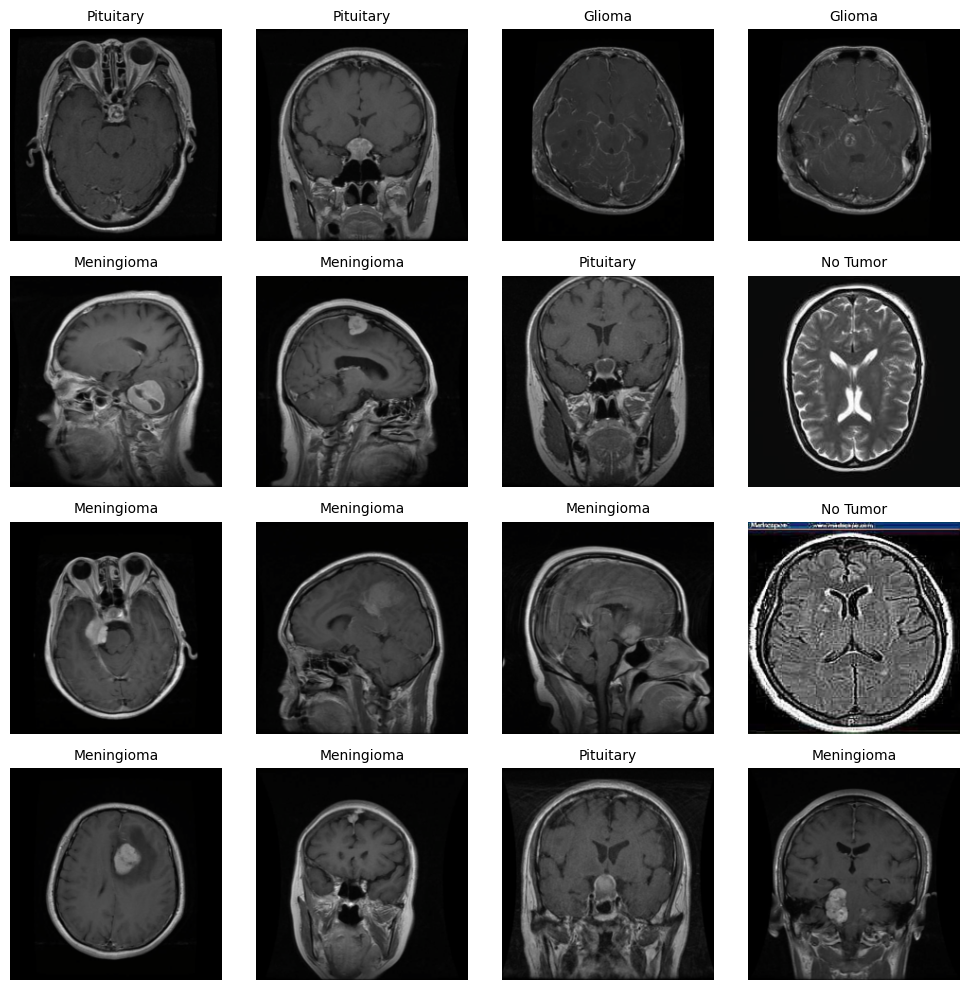

In [16]:
def imshow(input_images, labels):
    idx_to_class = {
        0: "No Tumor",
        1: "Glioma",
        2: "Meningioma",
        3: "Pituitary"
    }
    
    input_images = input_images.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input_images = std * input_images + mean
    input_images = np.clip(input_images, 0, 1)
    
    num_images = min(16, len(labels))  # take up to 16
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.flatten()
    
    for i in range(num_images):
        axes[i].imshow(input_images[i])
        axes[i].axis('off')
        axes[i].set_title(idx_to_class[int(labels[i])], fontsize=10)
    
    for j in range(num_images, 16):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()



train_iter = iter(train_loader)
images, labels = next(train_iter) 

imshow(images, labels)

## Class Distribution Visualization 

/tmp/ipykernel_19/2399579607.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(train_counts.index, rotation=45)
/tmp/ipykernel_19/2399579607.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(test_counts.index, rotation=45)


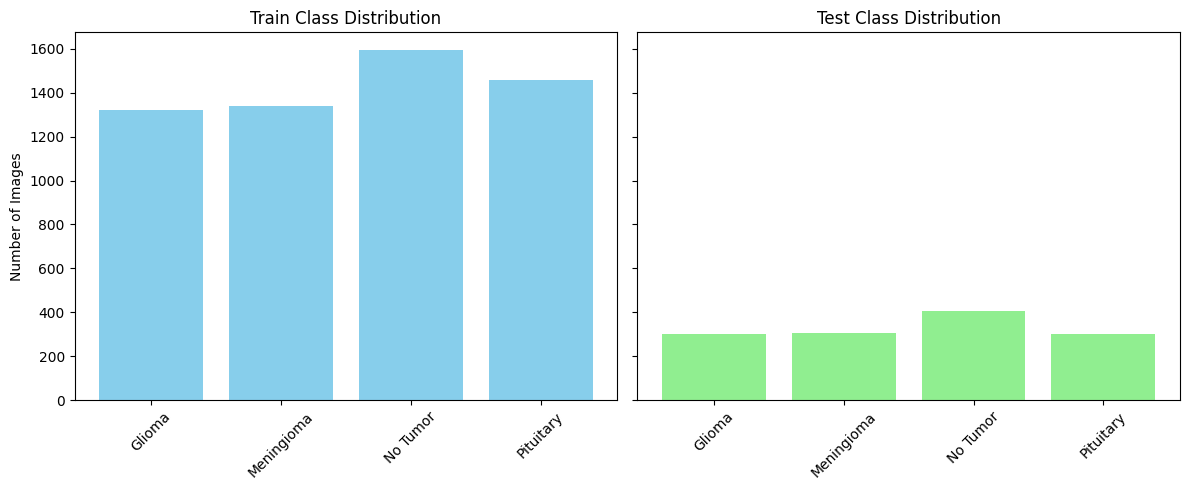

In [17]:
idx_to_class = {
    0: "No Tumor",
    1: "Glioma",
    2: "Meningioma",
    3: "Pituitary"
}

train_df['class_name'] = train_df['label'].map(idx_to_class)
test_df['class_name'] = test_df['label'].map(idx_to_class)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

#train 
train_counts = train_df['class_name'].value_counts().sort_index()
axes[0].bar(train_counts.index, train_counts.values, color="skyblue")
axes[0].set_title("Train Class Distribution")
axes[0].set_ylabel("Number of Images")
axes[0].set_xticklabels(train_counts.index, rotation=45)

#test
test_counts = test_df['class_name'].value_counts().sort_index()
axes[1].bar(test_counts.index, test_counts.values, color="lightgreen")
axes[1].set_title("Test Class Distribution")
axes[1].set_xticklabels(test_counts.index, rotation=45)

plt.tight_layout()
plt.show()
 

# 2. Model Architecture 

In [18]:
class MyModel(nn.Module):
    def __init__(self, num_classes=4):
        super(MyModel, self).__init__()
        
        self.model = nn.Sequential(
            
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),

            # Classifier
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x) 

In [19]:
model = MyModel(num_classes=4)
model = model.to(device)   

In [20]:
model.model[3]

Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

# 3. Training Setup

In [21]:
learning_rate = 0.0001
epoch = 10   

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  

# 4. Training and Plotting 

In [23]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, name="model"):
    model.to(device)

    train_losses = []
    val_losses = []
    train_accs = []   
    val_accs = []   

    for epoch in range(epochs):
        
        model.train()
        
        total_loss, correct, total = 0, 0, 0
        
        for images, labels in train_loader:
            # move data to gpu
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            
            #forward pass 
            outputs = model(images)
            
            # calculate loss
            loss = criterion(outputs, labels)
            
            # back pass
            loss.backward()
            
            # update grads
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = total_loss / len(train_loader)
        epoch_train_acc = 100 * correct / total

        # Validation
        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                
                images, labels = images.to(device), labels.to(device)
                
                 #forward pass 
                outputs = model(images)

                # calculate loss
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * correct_val / total_val

        # save metrics
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)

        # Logging
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")

    return train_losses, val_losses, train_accs, val_accs


In [24]:
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs_range = range(1, len(train_losses)+1)

    plt.figure(figsize=(12,5))

    #loss
    plt.subplot(1,2,1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()

    #accuracy  
    plt.subplot(1,2,2)
    plt.plot(epochs_range, train_accs, label="Train Acc")
    plt.plot(epochs_range, val_accs, label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training & Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show() 

# 5. Model Training and Visualization 

In [25]:
train_losses, val_losses, train_accs, val_accs = train_model(
    model=model , 
    train_loader=train_loader, 
    val_loader=test_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    epochs=10 
)    

Epoch [1/10] Train Loss: 0.6443, Train Acc: 75.09% | Val Loss: 0.5815, Val Acc: 78.95%
Epoch [2/10] Train Loss: 0.3791, Train Acc: 85.80% | Val Loss: 0.3985, Val Acc: 85.35%
Epoch [3/10] Train Loss: 0.2605, Train Acc: 90.42% | Val Loss: 0.3033, Val Acc: 88.94%
Epoch [4/10] Train Loss: 0.1985, Train Acc: 92.68% | Val Loss: 0.2645, Val Acc: 91.00%
Epoch [5/10] Train Loss: 0.1611, Train Acc: 94.42% | Val Loss: 0.2586, Val Acc: 91.38%
Epoch [6/10] Train Loss: 0.1172, Train Acc: 96.08% | Val Loss: 0.2036, Val Acc: 93.67%
Epoch [7/10] Train Loss: 0.0895, Train Acc: 97.43% | Val Loss: 0.1857, Val Acc: 94.20%
Epoch [8/10] Train Loss: 0.0705, Train Acc: 97.76% | Val Loss: 0.2066, Val Acc: 93.14%
Epoch [9/10] Train Loss: 0.0505, Train Acc: 98.72% | Val Loss: 0.3184, Val Acc: 90.01%
Epoch [10/10] Train Loss: 0.0473, Train Acc: 98.69% | Val Loss: 0.1815, Val Acc: 94.89%


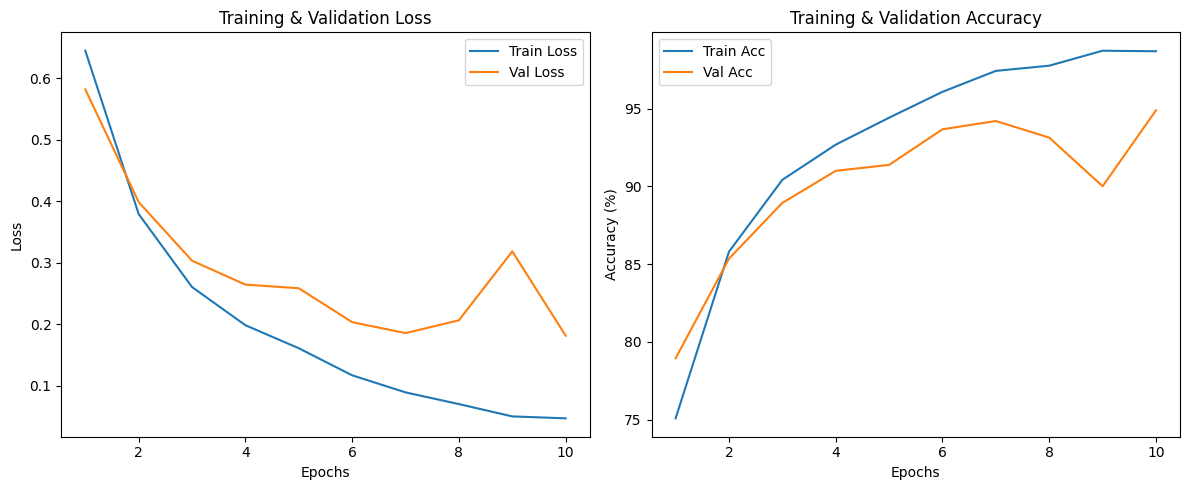

In [26]:
plot_metrics(train_losses, val_losses, train_accs, val_accs)

# 6. Classification Report 

In [27]:
from sklearn.metrics import classification_report

def evaluate_classification_report(model, data_loader, device, idx_to_class):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            #forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            #move to cpu 
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    report = classification_report(
        all_labels,
        all_preds,
        target_names=[idx_to_class[i] for i in range(len(idx_to_class))],
        digits=4
    )
    print("Classification Report:\n")
    print(report)


In [28]:
evaluate_classification_report(model, test_loader, device, idx_to_class)  

Classification Report:

              precision    recall  f1-score   support

    No Tumor     0.9854    0.9975    0.9914       405
      Glioma     0.9239    0.8900    0.9066       300
  Meningioma     0.8903    0.9020    0.8961       306
   Pituitary     0.9834    0.9900    0.9867       300

    accuracy                         0.9489      1311
   macro avg     0.9458    0.9449    0.9452      1311
weighted avg     0.9487    0.9489    0.9487      1311



# 7. Model Interpretability 

## 1. Grad-CAM (Gradient-weighted Class Activation Mapping) 

In [29]:
!pip install grad-cam 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.2 MB/s 

Visualizing Grad-CAM for: /kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-pi_0086.jpg
True Label: Pituitary


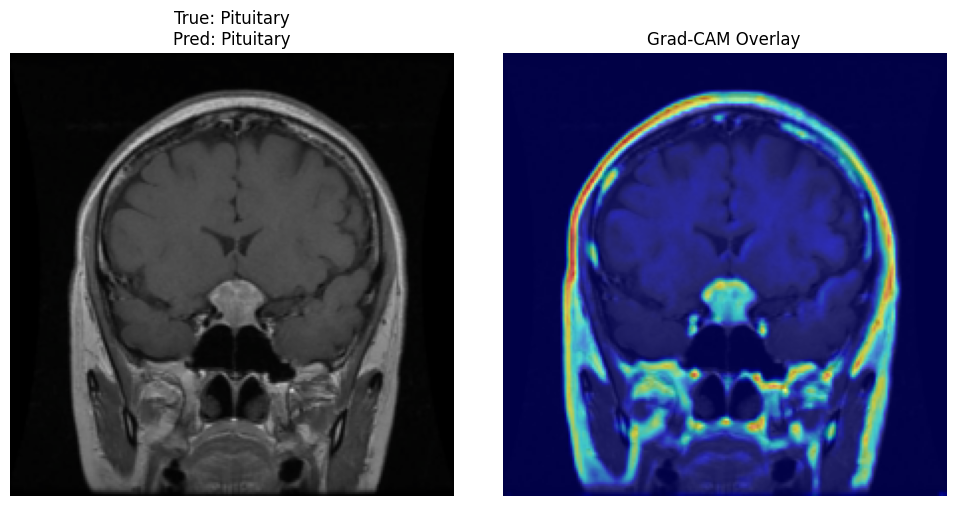

In [30]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

def load_and_preprocess_image(image_path, transform):
    
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image)
    # (C, H, W) -> (1, C, H, W)
    return image_tensor.unsqueeze(0)

def plot_grad_cam_for_mymodel(model, target_layer, image_path, transform, true_label=None):

    # Initialize GradCAM
    cam = GradCAM(model=model, target_layers=[target_layer])
    
    # Load and preprocess the image
    img_tensor = load_and_preprocess_image(image_path, transform).to(device)
    
    # forward pass
    with torch.no_grad():
        output = model(img_tensor)
        pred_idx = output.argmax(dim=1).item()

    
    targets = [ClassifierOutputTarget(pred_idx)]
    
    # CAM heatmap
    grayscale_cam = cam(input_tensor=img_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :] # Get the heatmap for the first (and only) image

    # original image for display 
    img_to_show = img_tensor.squeeze().cpu().numpy().transpose((1, 2, 0))
    mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
    img_to_show = std * img_to_show + mean
    img_to_show = np.clip(img_to_show, 0, 1)

    #Overlay the heatmap on the image
    visualization = show_cam_on_image(img_to_show, grayscale_cam, use_rgb=True, colormap=cv2.COLORMAP_JET)
    
   
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_to_show)
    title_text = f"Pred: {idx_to_class[pred_idx]}"
    if true_label is not None:
        title_text = f"True: {idx_to_class[true_label]}\n" + title_text
    plt.title(title_text)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title("Grad-CAM Overlay")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


sample_image_info = test_df.iloc[70] # test image 
sample_image_path = sample_image_info['file_path']
sample_true_label = sample_image_info['label']

print(f"Visualizing Grad-CAM for: {sample_image_path}")
print(f"True Label: {idx_to_class[sample_true_label]}")


target_layer_mymodel = model.model[3] #Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

plot_grad_cam_for_mymodel(
    model=model, 
    target_layer=target_layer_mymodel, 
    image_path=sample_image_path, 
    transform=custom_transform,
    true_label=sample_true_label
) 

Visualizing Grad-CAM for: /kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-no_0346.jpg
True Label: No Tumor


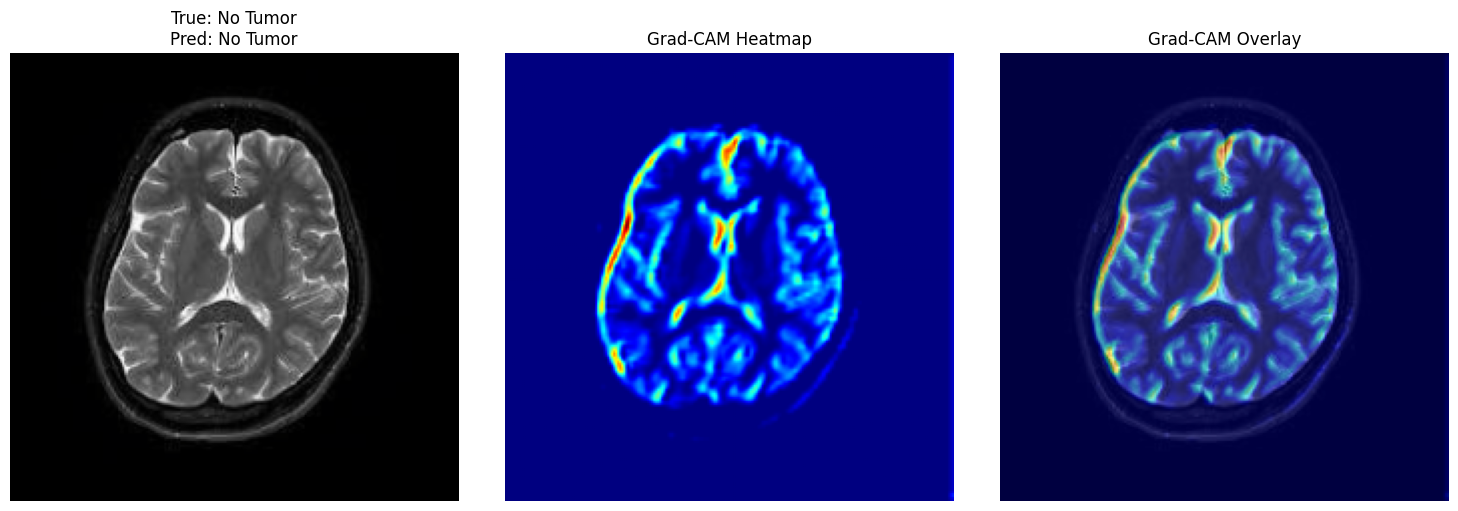

In [31]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import matplotlib.pyplot as plt 
import numpy as np
import torch
from PIL import Image

def load_and_preprocess_image(image_path, transform):

    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image)
    #(C, H, W) -> (1, C, H, W)
    return image_tensor.unsqueeze(0)

def plot_grad_cam_for_mymodel(model, target_layer, image_path, transform, true_label=None):

    #Initialize GradCAM
    cam = GradCAM(model=model, target_layers=[target_layer])
    
    #Load and preprocess the image
    img_tensor = load_and_preprocess_image(image_path, transform).to(device)
    
    #forward pass
    model.eval() 
    with torch.no_grad():
        output = model(img_tensor)
        pred_idx = output.argmax(dim=1).item()

    targets = [ClassifierOutputTarget(pred_idx)]
    
    #CAM heatmap
    grayscale_cam = cam(input_tensor=img_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :] # Get the heatmap for the first (and only) image

    #original image
    img_to_show = img_tensor.squeeze().cpu().numpy().transpose((1, 2, 0))
    mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
    img_to_show = std * img_to_show + mean
    img_to_show = np.clip(img_to_show, 0, 1)

    #heatmap 
    heatmap_display = cv2.resize(grayscale_cam, (img_to_show.shape[1], img_to_show.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_display), cv2.COLORMAP_JET)
    heatmap_colored_rgb = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) / 255.0 # Normalize to 0-1

    #Overlay the heatmap on the image
    visualization = show_cam_on_image(img_to_show, grayscale_cam, use_rgb=True, colormap=cv2.COLORMAP_JET)
    
   
    plt.figure(figsize=(15, 5))
    
    
    plt.subplot(1, 3, 1) 
    plt.imshow(img_to_show)
    title_text = f"Pred: {idx_to_class[pred_idx]}"
    if true_label is not None:
        title_text = f"True: {idx_to_class[true_label]}\n" + title_text
    plt.title(title_text)
    plt.axis('off')

   
    plt.subplot(1, 3, 2) 
    plt.imshow(heatmap_colored_rgb)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

  
    plt.subplot(1, 3, 3) 
    plt.imshow(visualization)
    plt.title("Grad-CAM Overlay")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


sample_image_info = test_df.iloc[303] # test image 
sample_image_path = sample_image_info['file_path']
sample_true_label = sample_image_info['label']

print(f"Visualizing Grad-CAM for: {sample_image_path}")
print(f"True Label: {idx_to_class[sample_true_label]}")

target_layer_mymodel = model.model[3] #Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

plot_grad_cam_for_mymodel(
    model=model, 
    target_layer=target_layer_mymodel, 
    image_path=sample_image_path, 
    transform=custom_transform,
    true_label=sample_true_label
) 

## 2. LIME (Local Interpretable Model-agnostic Explanations) 

Visualizing LIME for: /kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-no_0346.jpg
True Label: No Tumor


  0%|          | 0/1000 [00:00<?, ?it/s]

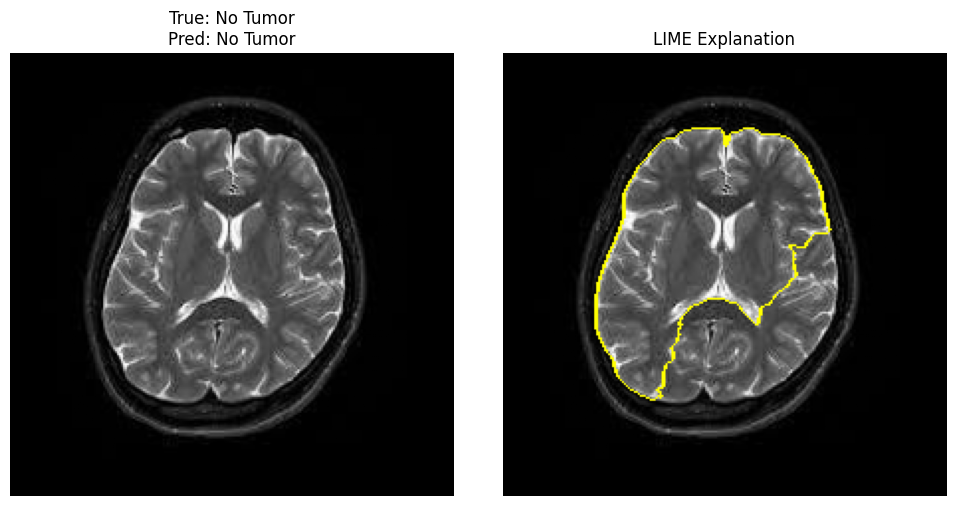

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.segmentation import mark_boundaries
import lime
from lime import lime_image

def predict_for_lime(numpy_images):
   
    # (N, H, W, C) to (N, C, H, W)
    images = torch.from_numpy(numpy_images).permute(0, 3, 1, 2).float().to(device)

    normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    images = normalizer(images)

    model.eval()
    with torch.no_grad():
        outputs = model(images)

    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    
    return probabilities.cpu().numpy()


def visualize_lime(model, image_path, transform, true_label=None):

    original_image = Image.open(image_path).convert("RGB")
    original_image_resized = original_image.resize(target_size) 
    image_np = np.array(original_image_resized) / 255.0 

   
    explainer = lime_image.LimeImageExplainer()

    explanation = explainer.explain_instance(
        image_np,
        predict_for_lime,
        top_labels=1,       
        hide_color=0,
        num_samples=1000      
    )
    
   
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,       
        hide_rest=False        
    )
    
 
    img_tensor = transform(original_image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        pred_idx = output.argmax(dim=1).item()
        pred_class = idx_to_class[pred_idx]

    
    plt.figure(figsize=(10, 5))
    
   
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    title_text = f"Pred: {pred_class}"
    if true_label is not None:
        title_text = f"True: {idx_to_class[true_label]}\n" + title_text
    plt.title(title_text)
    plt.axis('off')

    
    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title("LIME Explanation")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


sample_image_info = test_df.iloc[303]
sample_image_path = sample_image_info['file_path']
sample_true_label = sample_image_info['label']

print(f"Visualizing LIME for: {sample_image_path}")
print(f"True Label: {idx_to_class[sample_true_label]}")

visualize_lime(
    model=model, 
    image_path=sample_image_path, 
    transform=custom_transform,
    true_label=sample_true_label
) 

# 8. Saving Model 

In [33]:
MODEL_SAVE_PATH = "/kaggle/working/custom_cnn_tumor_model.pth"

torch.save(model.state_dict(), MODEL_SAVE_PATH)

print(f"Model saved to {MODEL_SAVE_PATH}")

Model saved to /kaggle/working/custom_cnn_tumor_model.pth


In [34]:
from IPython.display import FileLink

FileLink(MODEL_SAVE_PATH) 

/kaggle/working/custom_cnn_tumor_model.pth